Optimal number of clusters: 10 with DB Index: 0.79


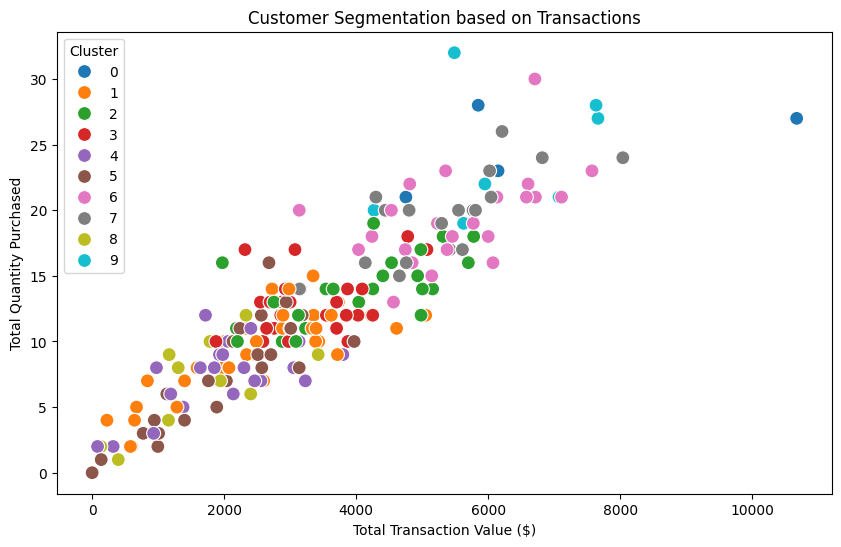

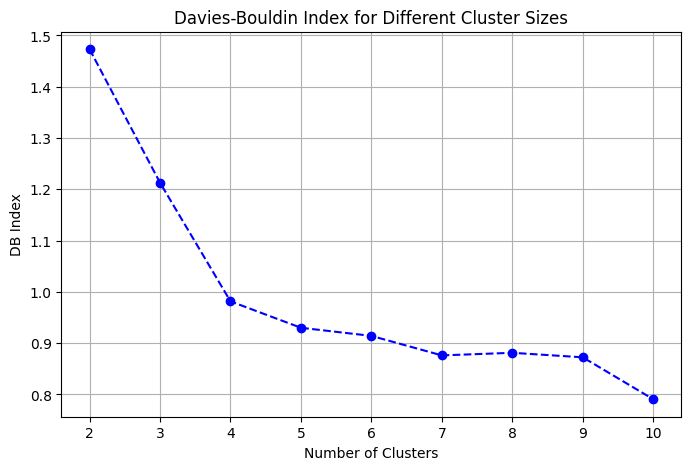

Customer segmentation data saved to 'Customer_Segments.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers_path = '/content/Customers (1).csv'
transactions_path = '/content/Transactions.csv'

# Read files into DataFrames
customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)

# Preprocess transaction data
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
transactions_df['TotalValue'] = pd.to_numeric(transactions_df['TotalValue'], errors='coerce')

# Aggregate transaction data by CustomerID
customer_transactions = transactions_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count'
}).rename(columns={'TransactionID': 'TransactionCount'}).reset_index()

# Merge customer and transaction data
customer_data = pd.merge(customers_df, customer_transactions, on='CustomerID', how='left')
customer_data.fillna(0, inplace=True)  # Replace NaN values with 0 for customers with no transactions

# Encode categorical variables (Region)
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Select features for clustering
features = customer_data[['TotalValue', 'Quantity', 'TransactionCount'] +
                          [col for col in customer_data.columns if 'Region_' in col]]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means clustering
optimal_clusters = None
optimal_db_index = float('inf')
k_range = range(2, 11)
db_indexes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_indexes.append(db_index)

    if db_index < optimal_db_index:
        optimal_db_index = db_index
        optimal_clusters = k
        best_cluster_labels = cluster_labels

print(f"Optimal number of clusters: {optimal_clusters} with DB Index: {optimal_db_index:.2f}")

# Add cluster labels to the customer data
customer_data['Cluster'] = best_cluster_labels

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='TotalValue', y='Quantity', hue='Cluster', palette='tab10', s=100)
plt.title('Customer Segmentation based on Transactions')
plt.xlabel('Total Transaction Value ($)')
plt.ylabel('Total Quantity Purchased')
plt.legend(title='Cluster')
plt.show()

# Visualize Davies-Bouldin Index across cluster sizes
plt.figure(figsize=(8, 5))
plt.plot(k_range, db_indexes, marker='o', linestyle='--', color='b')
plt.title('Davies-Bouldin Index for Different Cluster Sizes')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.xticks(k_range)
plt.grid()
plt.show()

# Save clustered data
customer_data.to_csv('Customer_Segments.csv', index=False)
print("Customer segmentation data saved to 'Customer_Segments.csv'.")
